### Trying to tie it all together


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")

In [2]:
# run this cell to initiate the function, then the pipeline *should* run smoothly
from sklearn.preprocessing import FunctionTransformer

def clean_func(df):
    #
    # Construction year
    df['construction_year'] = df['construction_year'].replace(0, np.nan)
    # Impute using region + installer
    df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Impute using region only (for rows still missing)
    df['construction_year'] = df.groupby('region')['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Use recorded year - 13
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['recorded_year'] = df['date_recorded'].dt.year
    df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 13)
    #
    # gps_height 
    df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x)
    # Fill using median per lga
    df['gps_height'] = df.groupby('lga')['gps_height'].fillna(df['gps_height'].median())
    # Fill any still missing using region median
    df['gps_height'] = df.groupby(['region'])['gps_height'].fillna(df['gps_height'].median())
    # Longitude and latitude
    df['longitude'] = df['longitude'].replace(0, np.nan)
    df['latitude'] = df['latitude'].where(df['latitude'] < -0.5, np.nan) # too close to the equator
    for i in ['latitude','longitude']: # loop to fill by lga, region
        df[i] = df.groupby(['lga'])[i].fillna(df[i].median())
        df[i] = df.groupby(['region'])[i].fillna(df[i].median())
    # population
    # Fill population using median by district_code
    df['population'] = df.groupby('lga')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fill any still missing with median by region, then overall median
    df['population'] = df.groupby('region')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    df['population'] = df['population'].fillna(df.population.median)
    # Bin the outcome, see how it behaves
    df['population'] = pd.cut(df['population'], [-1,1,25,90,160,260,9999999], labels=[0,0.2,0.3,0.4,0.6,1])
    df['population'] = df['population'].astype(float)
    #
    # amount_tsh
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: min(x, 15000))
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: np.power(x,0.3))
        ### Encode categorical variables
    # Encode 'quantity' (and typo fix: 'insufficent' -> 'insufficient')
    df['quantity'] = df['quantity'].replace({
        'enough': 1,
        'seasonal': 0.6,
        'insufficient': 0.4,
        'dry': 0,
        'unknown': 0
    })
    df.quantity = pd.to_numeric(df.quantity, errors='coerce')

    # Encode 'water_quality' as binary: good = 1, else 0
    df['water_quality'] = np.where(df['water_quality'] == 'soft', 1, 0)
    # Encode 'waterpoint_type' (1 = preferred type, 0 = everything else)
    preferred_waterpoint = ['communal standpipe multiple', 'communal standpipe']
    df['waterpoint_type'] = df['waterpoint_type'].apply(lambda x: 1 if x in preferred_waterpoint else 0)
    # Encode 'permit' as binary: True = 1, False, missing = 0
    df['permit'] = np.where(df['permit'] == True, 1, 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['payment'] = np.where(df['payment'] == 'never pay', 0, 1)
    # Encode 'source' (1 = preferred sources, 0 = everything else)
    preferred_sources = ['spring', 'river', 'rainwater harvesting']
    df['source'] = df['source'].apply(lambda x: 1 if x in preferred_sources else 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['extraction_type_class'] = np.where(df['extraction_type_class'] == 'gravity', 0, 1)
    # Encode 'scheme_management' (1 = VWC, others 0)
    df['scheme_management'] = np.where(df['scheme_management'] == 'VWC', 0, 1)
    # one hot encoder for basin 
    df = pd.get_dummies(data=df, columns=['basin'], drop_first=True, dtype=int) 
    df = df.drop(columns=['id',  'date_recorded', 'funder', 'installer', 'wpt_name', 'num_private',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'waterpoint_type_group',
       'ward', 'public_meeting', 'recorded_by', 'scheme_name', 'extraction_type', 'recorded_year',
       'extraction_type_group', 'management', 'management_group', 'payment_type',
       'quality_group', 'quantity_group', 'source_type', 'source_class'])
    df['tshXpayment'] = df.amount_tsh * df.payment
    df['extractXsource'] = df.extraction_type_class * df.source
    df['popXtsh'] = df.population * df.amount_tsh
    df['popXquant'] = df.population * df.quantity
    df['popXsource'] = df.population * df.source
    df['extractXheight'] = df.extraction_type_class * df.gps_height
    df['typeXsource'] = df.waterpoint_type * df.source
    df['typeXyear'] = df.waterpoint_type * df.construction_year
    df['yearXpop'] = df.construction_year * df.population
    df['quantXsource'] = df.quantity * df.source
    df['yearsq'] = np.sqrt(df.construction_year + 1)
    
    return df


print('ready for piping')

my_transformer = FunctionTransformer(clean_func) # still can't get this to work in the pipeline with the clf gris search


import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")

ready for piping


In [3]:
# set paths
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_path = os.path.join(parent_dir, 'data')
out_path = os.path.join(parent_dir, 'outputs')

# Read the files
le = LabelEncoder()
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv')) 
y = le.fit_transform(labels['status_group']) 

# for now, cleaning and scaling before the pipeline
scaler = MinMaxScaler().set_output(transform="pandas")
cleaned_X = clean_func(train)
model = scaler.fit(cleaned_X) 
X = model.transform(cleaned_X) 

# Define features and target = y_encoded
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


/tmp/ipykernel_6904/4122603560.py:24: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['gps_height'] = df.groupby('lga')['gps_height'].fillna(df['gps_height'].median())
/tmp/ipykernel_6904/4122603560.py:26: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['gps_height'] = df.groupby(['region'])['gps_height'].fillna(df['gps_height'].median())
/tmp/ipykernel_6904/4122603560.py:31: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[i] = df.grou

In [5]:
# the big show - I'd like to play more with parameters, but I think we're out of time

from xgboost import XGBClassifier


xgboost = XGBClassifier(objective='multi:softprob', num_class=3)


clf = GridSearchCV(
    xgboost,
    {'objective': ['multiclass'],
    'eval_metric': ['auc'], 
    'num_class': [3],
    'gamma': [0.3, 0.5, 1, 2], # gamma
    'max_delta_step': [1, 2, 4], 
    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3], # eta
    'max_depth': [6, 8],
    'min_child_weight': [1, 3, 5]
#    'n_estimators': [100, 200],
#    'subsample': [0.8, 1.0],
#    'colsample_bytree': [0.8, 1.0]
    },
    verbose=1,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc_ovr_weighted',
) 

# Grid search
#grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)


best_model = clf.best_estimator_



# Check best_estimator_
print(" Type:", type(clf))
print(" Best Estimator:", clf.best_estimator_)




Fitting 5 folds for each of 360 candidates, totalling 1800 fits
0.8687091504005636
{'eval_metric': 'auc', 'gamma': 0.3, 'learning_rate': 0.2, 'max_delta_step': 1, 'max_depth': 8, 'min_child_weight': 1, 'num_class': 3, 'objective': 'multiclass'}
 Type: <class 'sklearn.model_selection._search.GridSearchCV'>
 Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, 

In [55]:
# make prediction with whole train set, save for streamlit
# reload data just in case
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
# predict the data on the full set, then change it back to strings
yhat = clf.predict(X)
yhat = le.inverse_transform(yhat)
# add it to the original data set, as well as the true labels
train['predicted'] = yhat
output = df = pd.merge(train, labels, on='id')
# save it
output.to_csv(os.path.join(data_path, 'data_predicted.csv'), index=False)

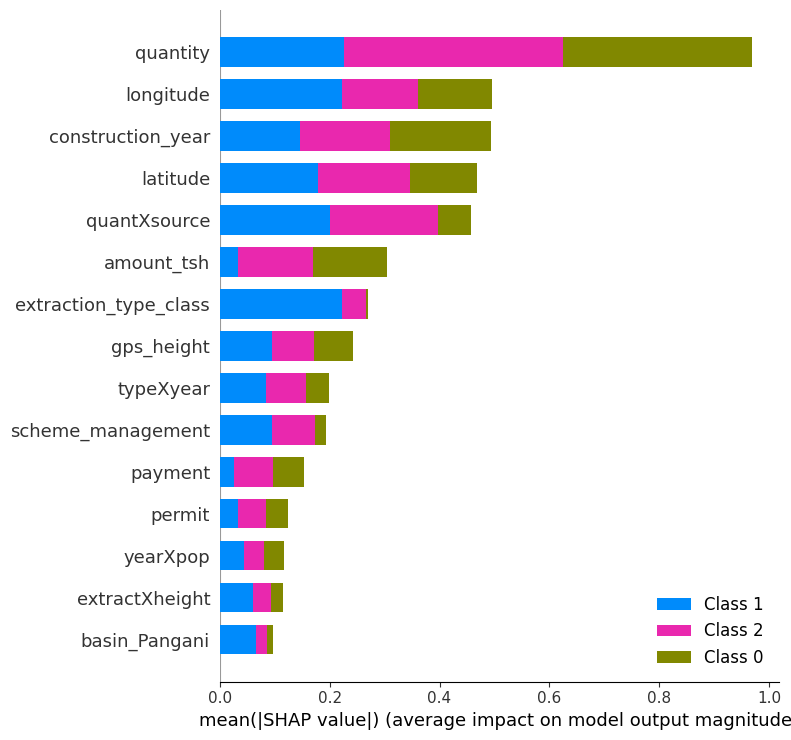

In [56]:
import shap

# Calculate SHAP values
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_train)

shap_values = explainer(X_train)

# Visualize SHAP values
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=15)



In [30]:
# explainer = shap.TreeExplainer(model)

expected_value = explainer.expected_value

select = range(20)
features = X_test.iloc[select]
features_display = X_train.loc[features.index]

shap.decision_plot(expected_value, shap_values, features_display)



KeyError: "None of [Index([19321,  9219, 32072, 21900, 55124, 52874, 28838, 11204, 32273, 38249,\n       41607, 33265, 12425, 29161, 33007, 26297, 38647, 18463, 50402, 38170],\n      dtype='int64')] are in the [index]"

In [6]:
# old code results, don't run this cell

 Type: <class 'sklearn.model_selection._search.GridSearchCV'>
 Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, ...)
 Classification Report on Test Set:
                         precision    recall  f1-score   support

             functional       0.75      0.89      0.82      9678
functional nee

Best Parameters Found:
{'eval_metric': 'auc', 'gamma': 0.3, 'learning_rate': 0.2, 'max_delta_step': 1, 'max_depth': 8, 'min_child_weight': 1, 'num_class': 3, 'objective': 'multiclass'}


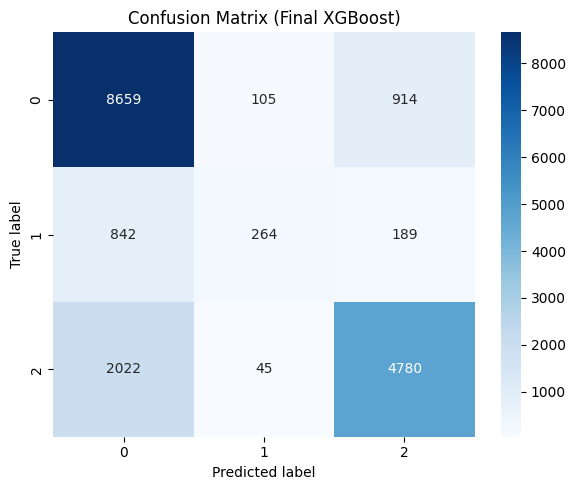

In [47]:
# like most above, this is stolen from Fatemeh

print("Best Parameters Found:")
print(clf.best_params_)
 

# confusion matrix (rows=true, cols=predicted)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues" 
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Final XGBoost)")
plt.tight_layout()
plt.show()



,0
990.590271,amount_tsh
645.280273,gps_height
643.834656,longitude
827.491455,latitude
77.987831,population
628.982483,scheme_management
336.458740,permit
809.012756,construction_year
1296.977417,extraction_type_class
632.514404,payment


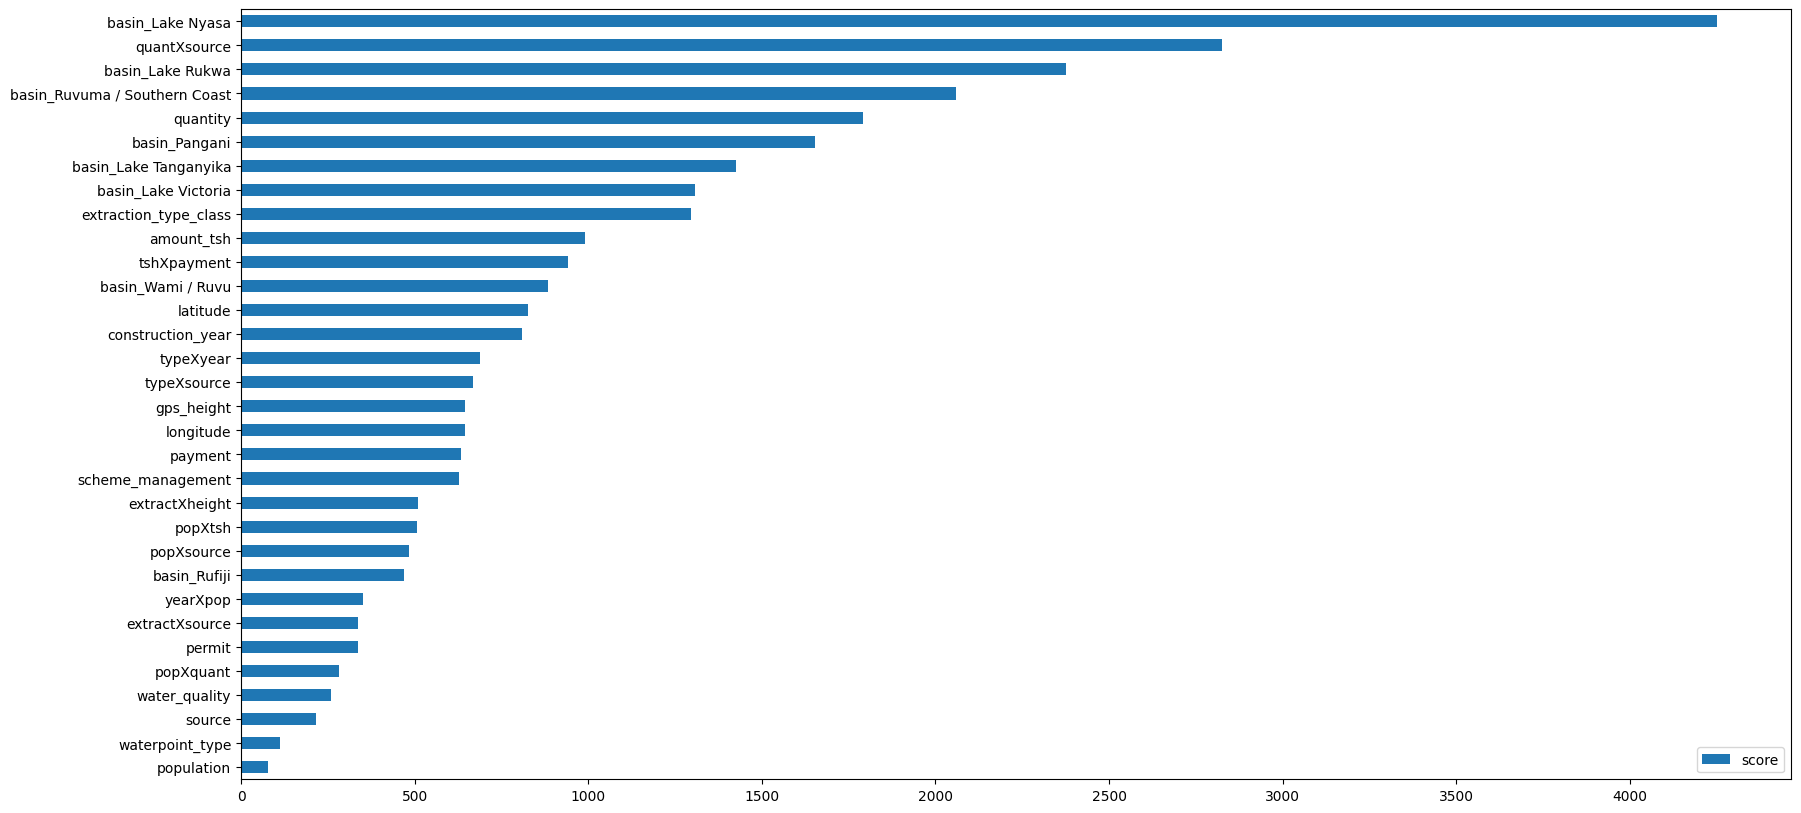

In [48]:
# new, stolen from substack, a bit of feature imporance. Try other importance_type options for more

feature_important = clf.best_estimator_.get_booster().get_score(importance_type='cover') # gain, weight, cover, total_gain, total_cover
keys = list(feature_important.keys())
values = list(feature_important.values())
df = pd.DataFrame(keys, values)


data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize = (20,10))
df

In [49]:
feature_important

{'amount_tsh': 990.5902709960938,
 'gps_height': 645.2802734375,
 'longitude': 643.8346557617188,
 'latitude': 827.491455078125,
 'population': 77.98783111572266,
 'scheme_management': 628.9824829101562,
 'permit': 336.458740234375,
 'construction_year': 809.0127563476562,
 'extraction_type_class': 1296.9774169921875,
 'payment': 632.514404296875,
 'water_quality': 259.2917175292969,
 'quantity': 1790.039794921875,
 'source': 215.10067749023438,
 'waterpoint_type': 112.83265686035156,
 'basin_Lake Nyasa': 4252.14794921875,
 'basin_Lake Rukwa': 2377.34130859375,
 'basin_Lake Tanganyika': 1424.7222900390625,
 'basin_Lake Victoria': 1307.0989990234375,
 'basin_Pangani': 1654.227783203125,
 'basin_Rufiji': 470.09197998046875,
 'basin_Ruvuma / Southern Coast': 2058.8583984375,
 'basin_Wami / Ruvu': 883.913818359375,
 'tshXpayment': 942.150634765625,
 'extractXsource': 338.04180908203125,
 'popXtsh': 505.7778015136719,
 'popXquant': 282.2187194824219,
 'popXsource': 483.9527893066406,
 'extr